# Web Visualizer Process

---

## 1. Import Modules

In [1]:
import os
from config.secret_keys import OPENAI_API_KEY, USER_AGENT, TAVILY_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['USER_AGENT'] = USER_AGENT

In [2]:
from pathlib import Path

BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data' # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / 'charts' # 차트 저장용 디엑토리

## 2. Import Modules

In [3]:
# Define State
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Define Tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
# import pandas as pd
# from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
# from langchain.agents.agent_types import AgentType

# Define Agent
from langchain_openai import ChatOpenAI

# Define Node
from langgraph.prebuilt import ToolNode

# Define Edges
from langgraph.prebuilt import tools_condition
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Prompts
from langchain_core.messages import SystemMessage, HumanMessage

## 3. Build Application

### 3-1. Define State

In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

### 3-1. Define Tools

In [5]:
# web search tool
web_search_tool = TavilySearchResults(max_results=3)

# python code interpreter
repl = PythonREPL()
@tool
def python_repl(
    code : Annotated[str, "The Python code to execute to generate your chart."]
):
    """
    Use this to execute python code.

    If you want to see the output of a value, you should print it out with 'print(...)'. chart labels should be written in English.

    This is visible to the user.

    Please make the chart and save in './charts' folder.
    """

    try : 
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error : {repr(e)}"
    
    result_str = f"Successfully executed: \n```python\n{code}\n```Stdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, repond with FINAL ANSWER."
    )

tools = [web_search_tool, python_repl]

### 3-2. Define Agent

In [6]:
llm = ChatOpenAI(
    model = "gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)

### 3-3. Define Nodes

In [7]:
def web_visualizer_node(state):
    result = llm_with_tools.invoke(state["messages"])
    return {'messages' : [result]}

tool_node = ToolNode(tools)

### 3-4. Define Conditional Edge Function

In [8]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

### 3-5. Build Graph

In [9]:
workflow = StateGraph(State)
memory = MemorySaver()

workflow.add_node("web_visualizer", web_visualizer_node)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "web_visualizer")

workflow.add_conditional_edges(
    "web_visualizer",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)

workflow.add_edge("tool", "web_visualizer")

app = workflow.compile(checkpointer=memory)

## 4. Visualize Graph

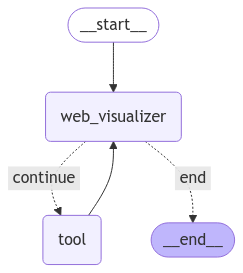

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Receving update from node: 'web_visualizer
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bfhB3Jj20fehiQqoBWs6gz26', 'function': {'arguments': '{"query":"US GDP data 2018 to 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 179, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-40d5a1f7-2dc0-41f4-a3c0-246608801d7b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'US GDP data 2018 to 2023'}, 'id': 'call_bfhB3Jj20fehiQqoBWs6gz26', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 28, 't

Python REPL can execute arbitrary code. Use with caution.


Receving update from node: 'web_visualizer
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_N2w1Ga6Si9g0sEDExg1kQW1w', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport numpy as np\\n\\n# GDP data for the US from 2018 to 2023\\nyears = [2018, 2019, 2020, 2021, 2022, 2023]\\n# These are hypothetical numbers for illustration purposes, replace them with actual data\\n# Example GDP in trillion USD\\ngdp = [20.5, 21.4, 20.9, 22.7, 23.3, 24.1]  # placeholder values\\n\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp, marker=\'o\')\\nplt.title(\'US GDP from 2018 to 2023\')\\nplt.xlabel(\'Year\')\\nplt.ylabel(\'GDP in Trillions USD\')\\nplt.grid(True)\\nplt.xticks(np.arange(2018, 2024, 1))\\nplt.yticks(np.arange(20, 25, 0.5))\\nplt.savefig(\'./charts/us_gdp_2018_to_2023.png\')\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 252, 'prompt_tokens

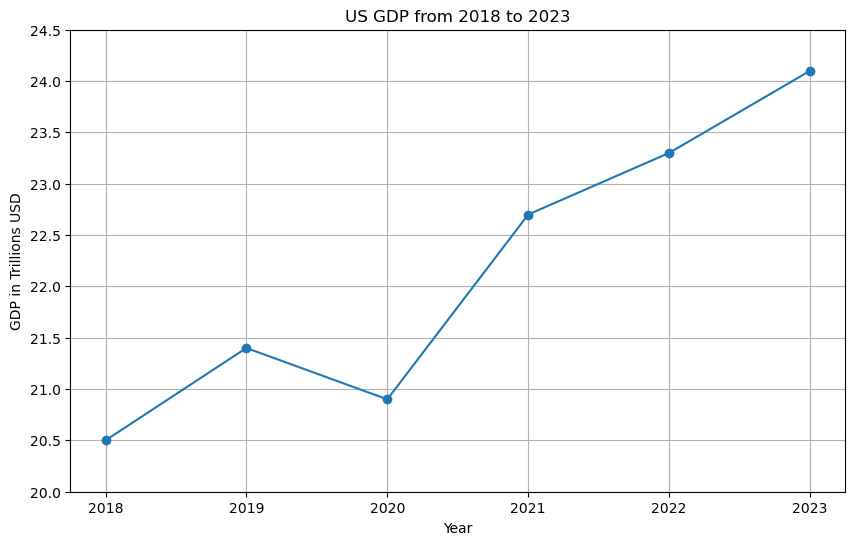

Receving update from node: 'tool
{'messages': [ToolMessage(content="Successfully executed: \n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# GDP data for the US from 2018 to 2023\nyears = [2018, 2019, 2020, 2021, 2022, 2023]\n# These are hypothetical numbers for illustration purposes, replace them with actual data\n# Example GDP in trillion USD\ngdp = [20.5, 21.4, 20.9, 22.7, 23.3, 24.1]  # placeholder values\n\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp, marker='o')\nplt.title('US GDP from 2018 to 2023')\nplt.xlabel('Year')\nplt.ylabel('GDP in Trillions USD')\nplt.grid(True)\nplt.xticks(np.arange(2018, 2024, 1))\nplt.yticks(np.arange(20, 25, 0.5))\nplt.savefig('./charts/us_gdp_2018_to_2023.png')\nplt.show()\n```Stdout: \n\nIf you have completed all tasks, repond with FINAL ANSWER.", name='python_repl', id='e21f6c3d-0977-43d1-b370-db0938d421c4', tool_call_id='call_N2w1Ga6Si9g0sEDExg1kQW1w')]}



Receving update from node: 'web_visualizer
{'messages': [AIMessag

In [11]:
initial_input = {'messages' : [HumanMessage(content="미국의 최근 5개년 (~2023) GDP 차트를 그래줄래?")]}
thread = {"configurable" : {"thread_id" : "2"}}

for chunk in app.stream(initial_input, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")